<a href="https://colab.research.google.com/github/CatherineDemian/Face-recognition-autoencoders-/blob/main/CAE_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initialization

In [ ]:
import os
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.metrics import accuracy_score
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

zip_path = '/content/drive/My Drive/archive.zip'
print(os.path.exists(zip_path))  # This should return True if the file exists

True


In [ ]:
# Extract dataset
def extract_dataset(zip_path, output_path):
    """
    Extract the dataset from a zip file to the given output path.

    Parameters:
    - zip_path: Path to the zip file containing the dataset.
    - output_path: Directory where the extracted files will be saved.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

zip_path = '/content/drive/My Drive/archive.zip'
data_path = '/content/casia_dataset'
output_path = '/content/split_dataset'

# Extract and load dataset
extract_dataset(zip_path, data_path)

In [ ]:

# Function to get image paths and labels, skipping the root folder
def load_images_and_labels(data_path):
    image_paths, labels = [], []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                image_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))  # Folder name as label
    print(f"Found {len(image_paths)} images across {len(set(labels))} labels.")
    return image_paths, labels

# Get image paths and labels, skipping the root folder
image_paths, labels = load_images_and_labels(data_path)

# Split the dataset into train, validation, and test sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Function to copy files to split directories
def copy_files(file_paths, file_labels, split_name, output_path):
    for file_path, label in zip(file_paths, file_labels):
        split_class_dir = f"{output_path}/{split_name}/{label}"
        os.makedirs(split_class_dir, exist_ok=True)
        shutil.copy(file_path, f"{split_class_dir}/{os.path.basename(file_path)}")


# Copy dataset splits
copy_files(train_files, train_labels, "train", output_path)
copy_files(val_files, val_labels, "val", output_path)
copy_files(test_files, test_labels, "test", output_path)

# Verify the splits
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_path, split)
    print(f"{split.capitalize()} has {len(os.listdir(split_dir))} classes.")


Found 20197 images across 200 labels.
Train has 200 classes.
Val has 200 classes.
Test has 200 classes.


100 classes

In [ ]:


# Function to get image paths and labels, skipping the root folder
def load_images_and_labels(data_path, num_classes=None):
    image_paths, labels = [], []
    label_count = {}  # To keep track of the number of classes

    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                label = os.path.basename(root)  # Folder name as label
                # Only add files if the label count is within the limit
                if num_classes is None or label_count.get(label, 0) < num_classes:
                    image_paths.append(os.path.join(root, file))
                    labels.append(label)
                    label_count[label] = label_count.get(label, 0) + 1

    # Reduce to only the first `num_classes` unique classes if specified
    if num_classes:
        unique_labels = sorted(set(labels))[:num_classes]
        filtered_data = [(path, lbl) for path, lbl in zip(image_paths, labels) if lbl in unique_labels]
        image_paths, labels = zip(*filtered_data)

    print(f"Found {len(image_paths)} images across {len(set(labels))} labels.")
    return list(image_paths), list(labels)

# Specify the number of classes to keep
NUM_CLASSES = 100

# Get image paths and labels, limiting to NUM_CLASSES
image_paths, labels = load_images_and_labels(data_path, num_classes=NUM_CLASSES)

# Split the dataset into train, validation, and test sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Function to copy files to split directories
def copy_files(file_paths, file_labels, split_name, output_path):
    for file_path, label in zip(file_paths, file_labels):
        split_class_dir = f"{output_path}/{split_name}/{label}"
        os.makedirs(split_class_dir, exist_ok=True)
        shutil.copy(file_path, f"{split_class_dir}/{os.path.basename(file_path)}")

# Output path for the split datasets
output_path = "output_dataset"

# Copy dataset splits
copy_files(train_files, train_labels, "train", output_path)
copy_files(val_files, val_labels, "val", output_path)
copy_files(test_files, test_labels, "test", output_path)

# Verify the splits
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_path, split)
    class_dirs = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
    print(f"{split.capitalize()} has {len(class_dirs)} classes.")


Found 10000 images across 100 labels.
Train has 100 classes.
Val has 100 classes.
Test has 100 classes.


### No of samples per split

In [ ]:
def count_samples_in_split(split_name):
    split_dir = os.path.join(output_path, split_name)
    class_counts = {}
    total_samples = 0

    for class_dir in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            num_images = len(os.listdir(class_path))
            class_counts[class_dir] = num_images
            total_samples += num_images

    return class_counts, total_samples

# Count samples for train, validation, and test
for split in ["train", "val", "test"]:
    class_counts, total_samples = count_samples_in_split(split)
    print(f"\n{split.capitalize()} split:")
    print(f"Total samples: {total_samples}")
    print(f"Samples per class:")
    for class_name, count in class_counts.items():
        print(f"  Class {class_name}: {count} samples")


Train split:
Total samples: 7000
Samples per class:
  Class 000008: 70 samples
  Class 000178: 70 samples
  Class 000083: 70 samples
  Class 000056: 70 samples
  Class 000057: 70 samples
  Class 000016: 70 samples
  Class 000073: 70 samples
  Class 000023: 70 samples
  Class 000136: 70 samples
  Class 000012: 70 samples
  Class 000069: 70 samples
  Class 000176: 70 samples
  Class 000085: 70 samples
  Class 000149: 70 samples
  Class 000200: 70 samples
  Class 000129: 70 samples
  Class 000198: 70 samples
  Class 000214: 70 samples
  Class 000034: 70 samples
  Class 000166: 70 samples
  Class 000014: 70 samples
  Class 000054: 70 samples
  Class 000170: 70 samples
  Class 000130: 70 samples
  Class 000026: 70 samples
  Class 000209: 70 samples
  Class 000010: 70 samples
  Class 000081: 70 samples
  Class 000128: 70 samples
  Class 000203: 70 samples
  Class 000003: 70 samples
  Class 000234: 70 samples
  Class 000037: 70 samples
  Class 000187: 70 samples
  Class 000088: 70 samples
  

In [ ]:
# Normalize images
def normalize_image(img):
    mean = np.mean(img, axis=(0, 1,), keepdims=True)
    std = np.std(img, axis=(0, 1), keepdims=True)
    return (img - mean) / (std + 1e-7)


In [ ]:
def load_and_normalize_dataset(split_dir):
    images, labels = [], []
    for label in sorted(os.listdir(split_dir)):
        label_dir = f"{split_dir}/{label}"
        for file_name in sorted(os.listdir(label_dir)):
            img = cv2.imread(f"{label_dir}/{file_name}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))  # Resize images for consistency
            images.append(normalize_image(img))
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
  # Normalize and visualize dataset
train_images, train_labels = load_and_normalize_dataset(f"{output_path}/train")
val_images, val_labels = load_and_normalize_dataset(f"{output_path}/val")
test_images, test_labels = load_and_normalize_dataset(f"{output_path}/test")

In [ ]:
train_images.shape

(7000, 64, 64, 3)

Visualizing Train set:


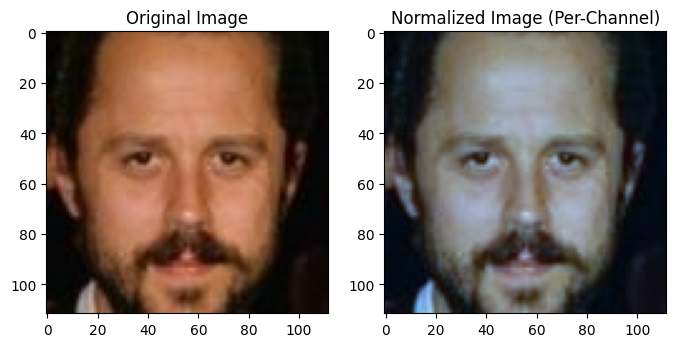

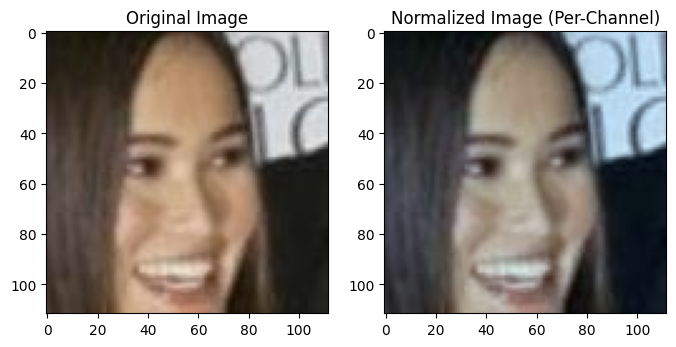

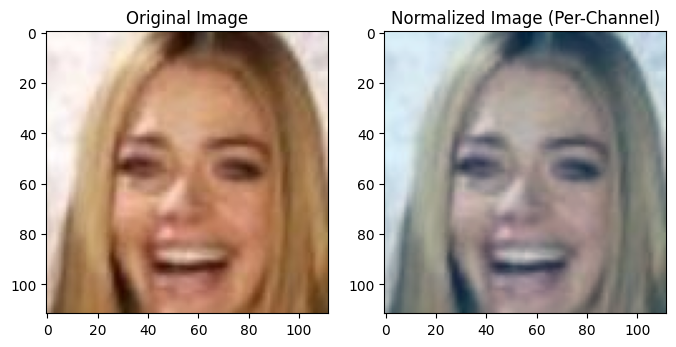

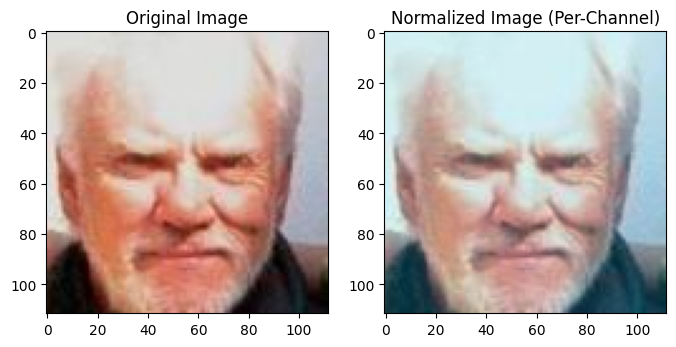

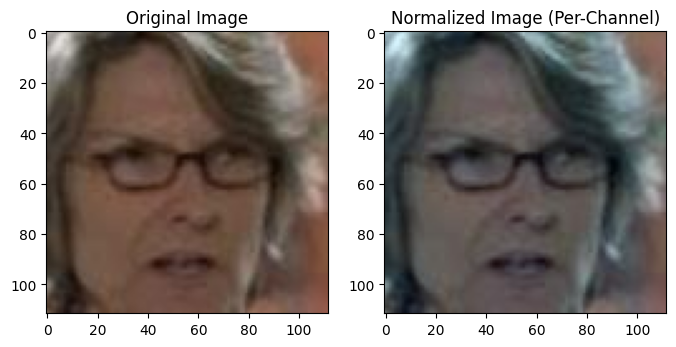

Visualizing Validation set:


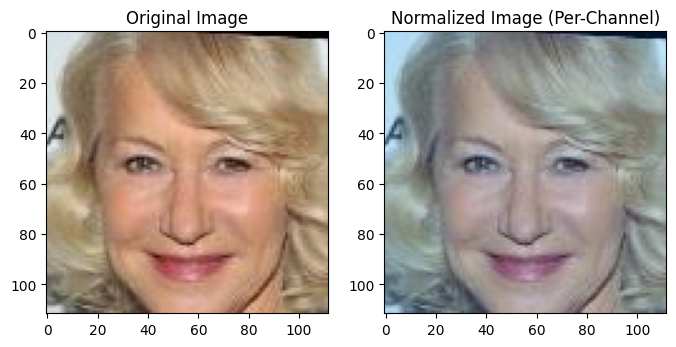

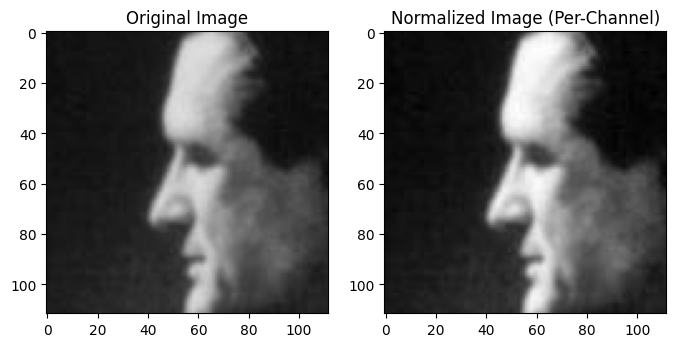

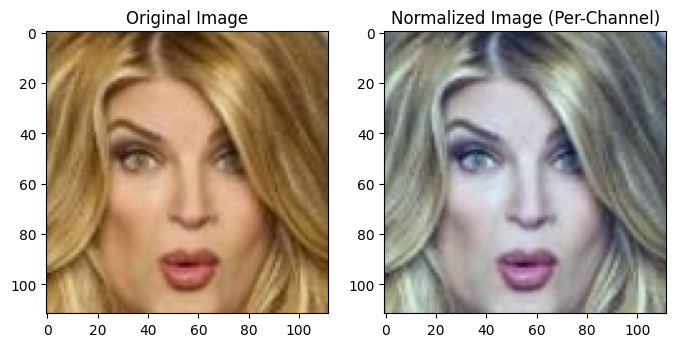

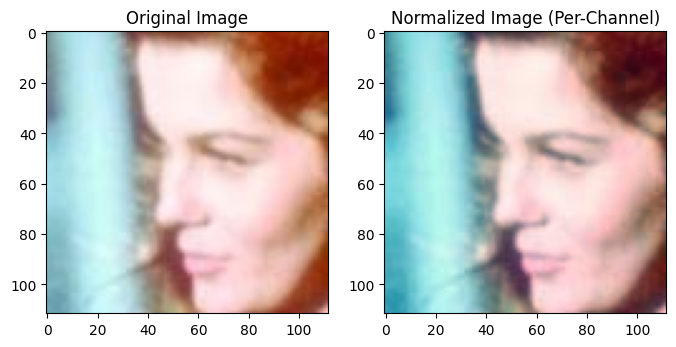

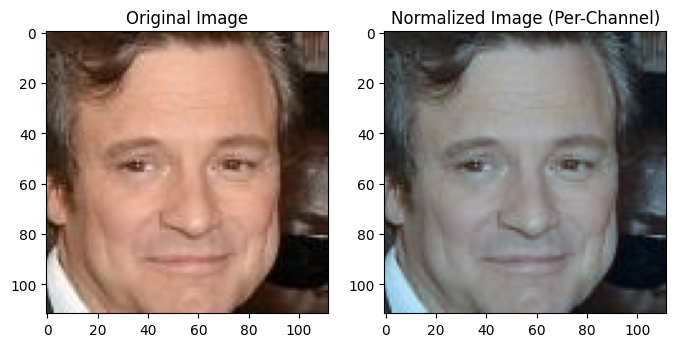

Visualizing Test set:


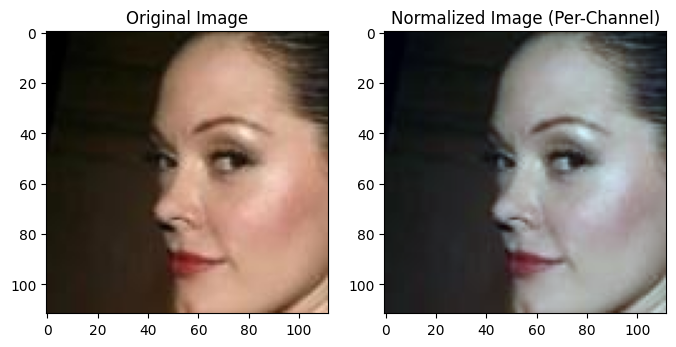

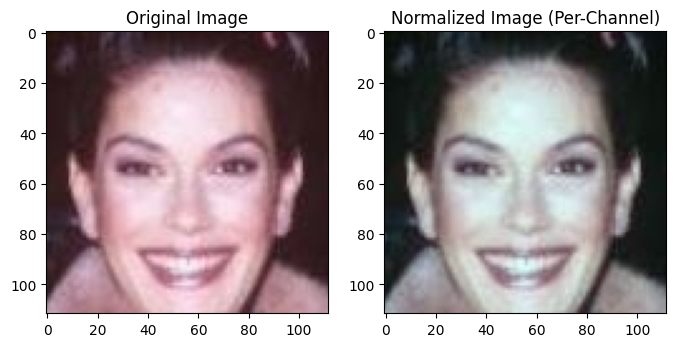

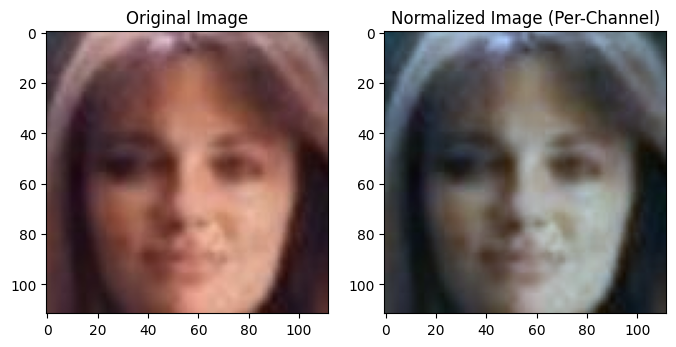

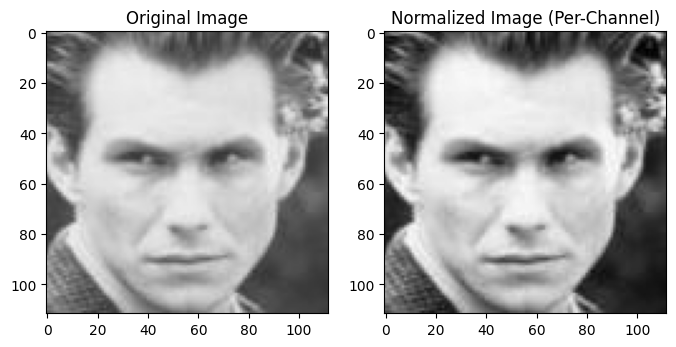

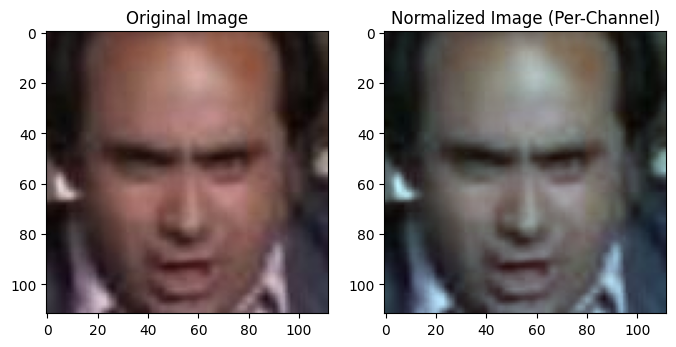

In [ ]:
def visualize_normalization(original_img, normalized_img):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[1].imshow((normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min()))  # Rescale for visualization
    axes[1].set_title("Normalized Image (Per-Channel)")
    plt.show()
def process_and_visualize(dataset_files, title):
    print(f"Visualizing {title} set:")
    for img_path in dataset_files[:5]:  # Visualize the first 5 images
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        normalized_img = normalize_image(original_img)
        visualize_normalization(original_img, normalized_img)

process_and_visualize(train_files, "Train")
process_and_visualize(val_files, "Validation")
process_and_visualize(test_files, "Test")

Numpy To tensors

In [ ]:
train_images_tensors = tf.convert_to_tensor(train_images, dtype=tf.float32)
val_images_tensors = tf.convert_to_tensor(val_images, dtype=tf.float32)
test_images_tensors = tf.convert_to_tensor(test_images, dtype=tf.float32)

train_labels_int = np.array([int(label) for label in train_labels], dtype=np.int32)
test_labels_int = np.array([int(label) for label in test_labels], dtype=np.int32)
val_labels_int = np.array([int(label) for label in val_labels], dtype=np.int32)

train_images_label_tensors = tf.convert_to_tensor(train_labels_int, dtype=tf.int32)
val_images_labe_tensors = tf.convert_to_tensor(test_labels_int, dtype=tf.int32)
test_images_label_tensors = tf.convert_to_tensor(val_labels_int, dtype=tf.int32)

unique_values = np.unique(test_images)
print(unique_values)

[-6.59325745 -6.49355164 -6.39384584 ... 11.6890479  12.92876101
 13.23868929]


In [ ]:
unique_values = np.unique(test_labels_int)
print(unique_values)

[  1   3   6   8   9  10  12  14  16  18  19  21  22  23  24  25  26  27
  31  32  33  34  35  36  37  38  39  41  43  46  47  51  54  56  57  58
  61  68  69  73  74  76  79  81  83  84  85  86  88  97 101 104 105 114
 128 129 130 136 137 138 145 147 148 149 152 157 165 166 168 169 170 172
 173 174 176 178 184 186 187 190 193 194 195 196 198 199 200 203 206 209
 214 217 220 221 229 231 234 237 238 240]


Training and

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - loss: 0.1629 - mse: 0.1629 - val_loss: 0.4664 - val_mse: 0.4664
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.2940 - val_mse: 0.2940
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.1284 - val_mse: 0.1284
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━

Final Training Loss: 0.0051
Final Validation Loss: 0.0048
Model saved as 'convolutional_autoencoder_rgb.h5'


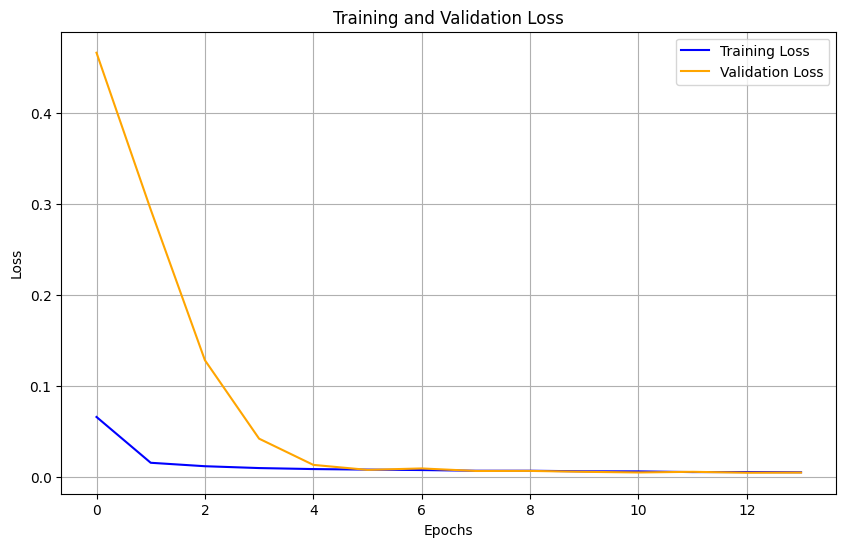

219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Input dimensions
IMG_HEIGHT = 112  # Adjust as needed
IMG_WIDTH = 112  # Adjust as needed

# Encoder-Decoder Architecture
input_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))  # Input RGB images

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='linear', padding='same')(x)

# Compile the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Create a new model for the latent space feature extraction
feature_vector_model = Model(input_img, encoded)

# Resize the RGB images to match input dimensions
train_images_resized = tf.image.resize(train_images, [IMG_HEIGHT, IMG_WIDTH])
val_images_resized = tf.image.resize(val_images, [IMG_HEIGHT, IMG_WIDTH])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)



# Train the autoencoder with the learning rate scheduler
history = autoencoder.fit(
    train_images_resized, train_images_resized,
    epochs=50,
    batch_size=64,  # Adjust batch size for your system's capacity
    validation_data=(val_images_resized, val_images_resized),
    callbacks=[early_stopping]
)

# Print the final training and validation loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Save the trained autoencoder
autoencoder.save('convolutional_autoencoder_rgb.h5')
print("Model saved as 'convolutional_autoencoder_rgb.h5'")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Use the feature vector model to generate feature vectors (latent representations)
latent_train = feature_vector_model.predict(train_images_resized)
latent_val = feature_vector_model.predict(val_images_resized)


In [ ]:
# Function to display original, normalized, and decoded images
def display_original_normalized_decoded(autoencoder, original_files, normalized_images):
    decoded_images = autoencoder.predict(normalized_images[:5])  # Decode the first 5 normalized images

    plt.figure(figsize=(18, 12))

    for i in range(5):  # Display the first 5 images
        # Load and display the original image
        original_img = cv2.imread(original_files[i])
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(original_img, (img_width, img_height))

        plt.subplot(5, 3, i * 3 + 1)
        plt.imshow(original_img / 255.0)  # Scale original image to [0, 1] for display
        plt.title("Original Image")
        plt.axis('off')

        # Display the normalized image
        plt.subplot(5, 3, i * 3 + 2)
        normalized_img = (normalized_images[i] - np.min(normalized_images[i])) / (
            np.max(normalized_images[i]) - np.min(normalized_images[i])
        )
        plt.imshow(normalized_img)
        plt.title("Normalized Image")
        plt.axis('off')

        # Display the decoded image
        plt.subplot(5, 3, i * 3 + 3)
        decoded_img = (decoded_images[i] - np.min(decoded_images[i])) / (
            np.max(decoded_images[i]) - np.min(decoded_images[i])
        )
        plt.imshow(decoded_img)
        plt.title("Reconstructed Image")
        plt.axis('off')

    plt.suptitle("Original vs Normalized vs recoustructed images",fontsize=18)
    plt.show()

# Call the function to visualize
display_original_normalized_decoded(autoencoder, train_files, train_images)

ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 112, 112, 3), found shape=(5, 64, 64, 3)

Validation Set Size: 50, Accuracy: 8.00%
Validation Set Size: 100, Accuracy: 8.00%
Validation Set Size: 200, Accuracy: 14.50%
Validation Set Size: 500, Accuracy: 16.00%
Validation Set Size: 1000, Accuracy: 15.20%
Validation Set Size: 3030, Accuracy: 14.36%


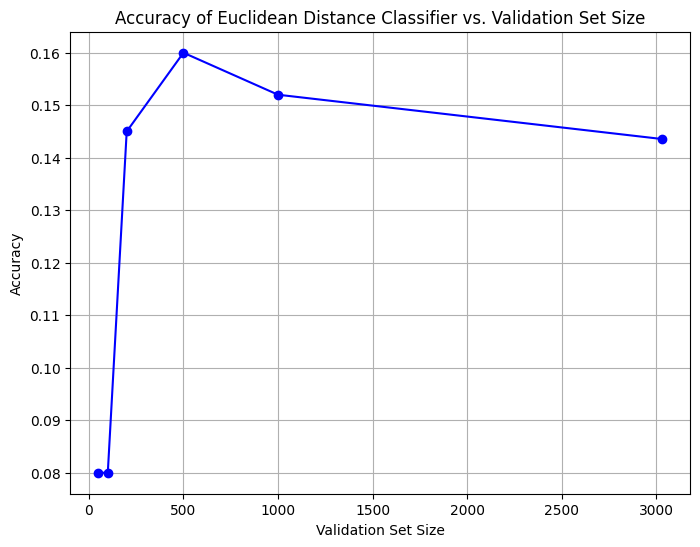

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

# Function to compute centroids for each class
def compute_centroids(latent_vectors, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([latent_vectors[labels == label].mean(axis=0) for label in unique_labels])
    return centroids, unique_labels

# Euclidean distance classifier
def euclidean_distance_classifier(latent_train, train_labels, latent_val, val_labels):
    # Compute centroids of the training set
    centroids, unique_labels = compute_centroids(latent_train, train_labels)

    # Compute Euclidean distances and classify validation points
    predicted_labels = []
    for val_point in latent_val:
        distances = np.linalg.norm(centroids - val_point, axis=1)
        predicted_label = unique_labels[np.argmin(distances)]
        predicted_labels.append(predicted_label)

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, predicted_labels)
    return accuracy

# Ensure the labels are numpy arrays and integer-encoded
train_labels = np.array(train_labels)  # Ensure train_labels are in numpy array format
val_labels = np.array(val_labels)  # Ensure val_labels are in numpy array format

# Ensure the images are correctly sized (resized if needed)
train_images_resized = tf.image.resize(train_images, [IMG_HEIGHT, IMG_WIDTH])
val_images_resized = tf.image.resize(val_images, [IMG_HEIGHT, IMG_WIDTH])

# Reshape the latent vectors to 2D (n_samples, n_features)
latent_train = latent_train.reshape(latent_train.shape[0], -1)
latent_val = latent_val.reshape(latent_val.shape[0], -1)

# Normalize latent vectors for consistent Euclidean distance calculations
latent_train = normalize(latent_train, axis=1)
latent_val = normalize(latent_val, axis=1)


# Example code to plot accuracy of the classifier on different subsets of the validation data
val_sizes = [50, 100, 200, 500, 1000, len(val_labels)]  # Different validation set sizes
accuracies = []

for val_size in val_sizes:
    # Use a subset of the validation set
    subset_val = latent_val[:val_size]
    subset_val_labels = val_labels[:val_size]

    # Compute accuracy for the subset
    accuracy = euclidean_distance_classifier(latent_train, train_labels, subset_val, subset_val_labels)
    accuracies.append(accuracy)

    # Print accuracy in percentage
    print(f"Validation Set Size: {val_size}, Accuracy: {accuracy * 100:.2f}%")

# Plot the accuracy vs. validation set size
plt.figure(figsize=(8, 6))
plt.plot(val_sizes, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Euclidean Distance Classifier vs. Validation Set Size')
plt.xlabel('Validation Set Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Optional: Visualize latent space using t-SNE
def visualize_latent_space(latent_vectors, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Latent Space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

# Uncomment the line below to visualize latent space (optional)
# visualize_latent_space(latent_train, train_labels)


Classifier with Normalization and PCA

Validation Set Size: 50, Accuracy: 6.00%
Validation Set Size: 100, Accuracy: 8.00%
Validation Set Size: 200, Accuracy: 14.50%
Validation Set Size: 500, Accuracy: 14.80%
Validation Set Size: 1000, Accuracy: 13.50%
Validation Set Size: 3030, Accuracy: 12.64%


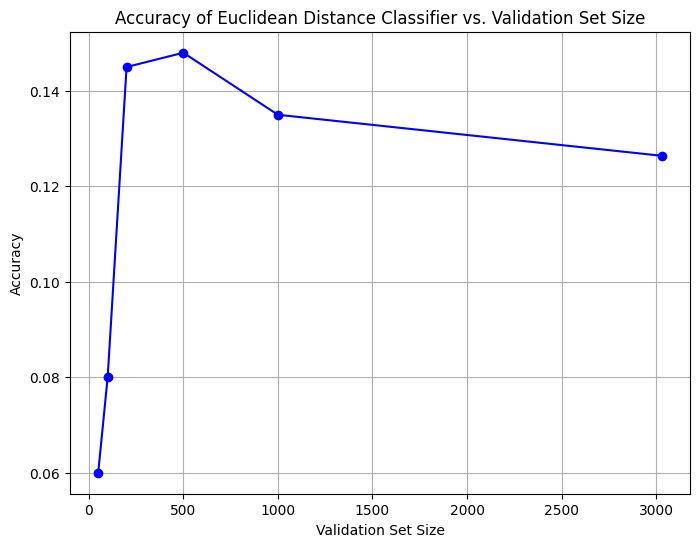

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

# Function to compute centroids for each class
def compute_centroids(latent_vectors, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([latent_vectors[labels == label].mean(axis=0) for label in unique_labels])
    return centroids, unique_labels

# Euclidean distance classifier
def euclidean_distance_classifier(latent_train, train_labels, latent_val, val_labels):
    # Compute centroids of the training set
    centroids, unique_labels = compute_centroids(latent_train, train_labels)

    # Compute Euclidean distances and classify validation points
    predicted_labels = []
    for val_point in latent_val:
        distances = np.linalg.norm(centroids - val_point, axis=1)
        predicted_label = unique_labels[np.argmin(distances)]
        predicted_labels.append(predicted_label)

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, predicted_labels)
    return accuracy

# Ensure the labels are numpy arrays and integer-encoded
train_labels = np.array(train_labels)  # Ensure train_labels are in numpy array format
val_labels = np.array(val_labels)  # Ensure val_labels are in numpy array format

# Ensure the images are correctly sized (resized if needed)
train_images_resized = tf.image.resize(train_images, [IMG_HEIGHT, IMG_WIDTH])
val_images_resized = tf.image.resize(val_images, [IMG_HEIGHT, IMG_WIDTH])

# Reshape the latent vectors to 2D (n_samples, n_features)
latent_train = latent_train.reshape(latent_train.shape[0], -1)
latent_val = latent_val.reshape(latent_val.shape[0], -1)

# Normalize latent vectors for consistent Euclidean distance calculations
latent_train = normalize(latent_train, axis=1)
latent_val = normalize(latent_val, axis=1)


# Example code to plot accuracy of the classifier on different subsets of the validation data
val_sizes = [50, 100, 200, 500, 1000, len(val_labels)]  # Different validation set sizes
accuracies = []

for val_size in val_sizes:
    # Use a subset of the validation set
    subset_val = latent_val[:val_size]
    subset_val_labels = val_labels[:val_size]

    # Compute accuracy for the subset
    accuracy = euclidean_distance_classifier(latent_train, train_labels, subset_val, subset_val_labels)
    accuracies.append(accuracy)

    # Print accuracy in percentage
    print(f"Validation Set Size: {val_size}, Accuracy: {accuracy * 100:.2f}%")

# Plot the accuracy vs. validation set size
plt.figure(figsize=(8, 6))
plt.plot(val_sizes, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Euclidean Distance Classifier vs. Validation Set Size')
plt.xlabel('Validation Set Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()



Validation Set Size: 10, Accuracy: 20.00%
Validation Set Size: 20, Accuracy: 15.00%
Validation Set Size: 50, Accuracy: 14.00%
Validation Set Size: 100, Accuracy: 12.00%
Validation Set Size: 150, Accuracy: 10.67%
Validation Set Size: 200, Accuracy: 11.50%


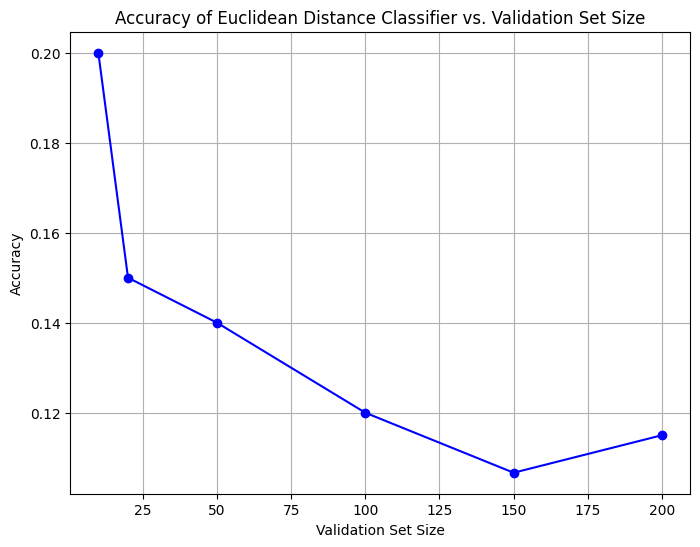

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

# Function to compute centroids for each class
def compute_centroids(latent_vectors, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([latent_vectors[labels == label].mean(axis=0) for label in unique_labels])
    return centroids, unique_labels

# Optimized Euclidean distance classifier
def euclidean_distance_classifier(latent_train, train_labels, latent_val, val_labels):
    # Compute centroids of the training set
    centroids, unique_labels = compute_centroids(latent_train, train_labels)

    # Compute distances and classify in a vectorized manner
    distances = np.linalg.norm(latent_val[:, None, :] - centroids[None, :, :], axis=2)
    predicted_labels = unique_labels[np.argmin(distances, axis=1)]

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, predicted_labels)
    return accuracy, predicted_labels

# Example Data Simulation (replace with your actual data)
np.random.seed(42)
latent_train = np.random.rand(1000, 128)  # 1000 samples with 128 features
latent_val = np.random.rand(200, 128)    # 200 samples with 128 features
train_labels = np.random.randint(0, 10, size=1000)  # 10 classes
val_labels = np.random.randint(0, 10, size=200)

# Normalize latent vectors
latent_train = normalize(latent_train, axis=1)
latent_val = normalize(latent_val, axis=1)

# Compute accuracy and generate predictions
accuracy, predictions = euclidean_distance_classifier(latent_train, train_labels, latent_val, val_labels)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(val_labels, predictions))

# Visualize latent space using t-SNE
def plot_latent_space(latent, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Plot latent space
plot_latent_space(latent_train, train_labels, "Latent Space of Training Data")
plot_latent_space(latent_val, val_labels, "Latent Space of Validation Data")


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3000)
pca.fit(latent_train.reshape(latent_train.shape[0], -1))

# Check explained variance ratio
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"✅ Total Explained Variance with 3000 Components: {explained_variance:.2f}")

visualization

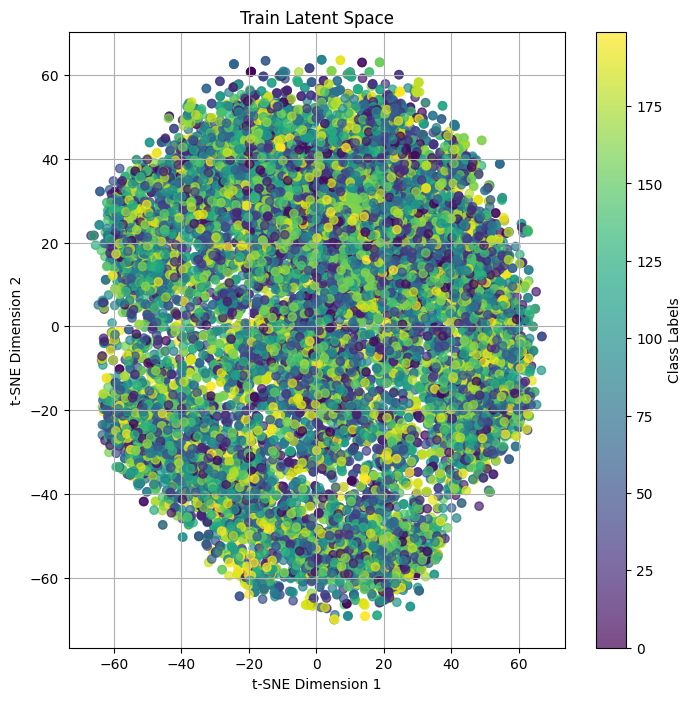

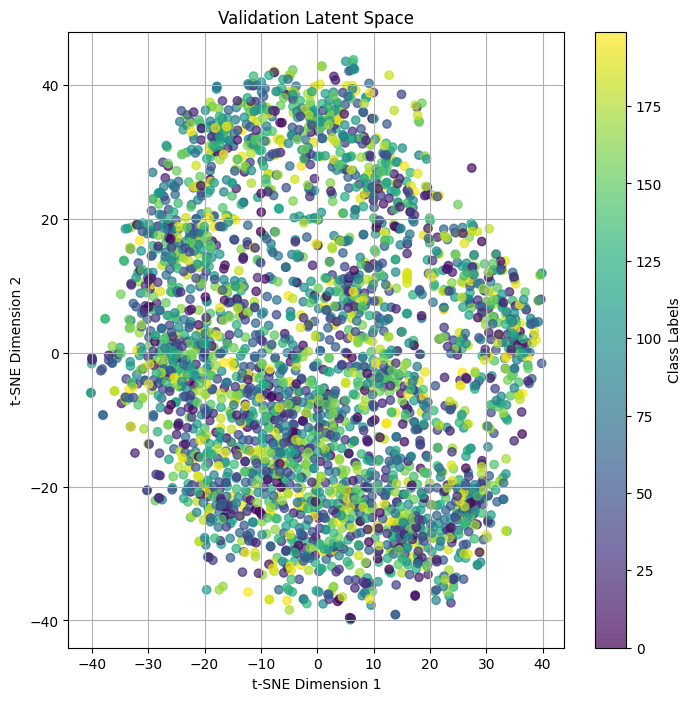

TypeError: cannot unpack non-iterable float object

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Function to visualize latent space using t-SNE
def visualize_latent_space(latent_vectors, labels, title="Latent Space Visualization"):
    # Convert string labels to numerical values
    le = LabelEncoder()
    numerical_labels = le.fit_transform(labels)

    tsne = TSNE(n_components=2, random_state=42)
    reduced_latent = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=numerical_labels, cmap='viridis', alpha=0.7)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Class Labels')

    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

# Function to visualize predictions with images
def plot_predictions_with_images(images, true_labels, predicted_labels):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray')  # Adjust color map based on image data (e.g., 'gray' or 'viridis')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to plot accuracy vs validation set size
def plot_accuracy_vs_val_size(val_sizes, accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(val_sizes, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Accuracy of Euclidean Distance Classifier vs. Validation Set Size')
    plt.xlabel('Validation Set Size')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# Example usage
# Ensure latent_train, train_labels, latent_val, val_labels, val_images, predictions, val_sizes, and accuracies are defined
try:
    # Visualize latent spaces
    visualize_latent_space(latent_train, train_labels, title="Train Latent Space")
    visualize_latent_space(latent_val, val_labels, title="Validation Latent Space")

    # Ensure predictions are generated before this call
    predictions, _ = euclidean_distance_classifier(latent_train, train_labels, latent_val, val_labels)
    plot_predictions_with_images(val_images[:10], val_labels[:10], predictions[:10])  # Visualize a subset of predictions

    # Plot accuracy vs validation set size
    plot_accuracy_vs_val_size(val_sizes, accuracies)

except NameError as e:
    print(f"NameError: {e}. Ensure all required variables are defined.")
except ValueError as e:
    print(f"ValueError: {e}. Check the data being passed to the functions.")


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3000)
pca.fit(latent_train.reshape(latent_train.shape[0], -1))

# Check explained variance ratio
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"✅ Total Explained Variance with 3000 Components: {explained_variance:.2f}")

✅ Total Explained Variance with 400 Components: 0.92


In [ ]:
for layer in autoencoder.layers:
    print(layer.name)


input_layer_4
conv2d_12
max_pooling2d_5
conv2d_13
max_pooling2d_6
conv2d_14
up_sampling2d_5
conv2d_15
up_sampling2d_6
conv2d_16


Original shape: (14137, 37632)
New shape after reshaping: (14137, 37632)

--- Fold 1/3 ---


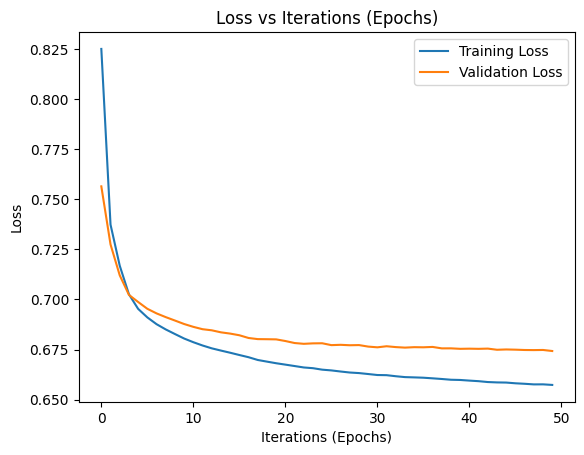


--- Fold 2/3 ---


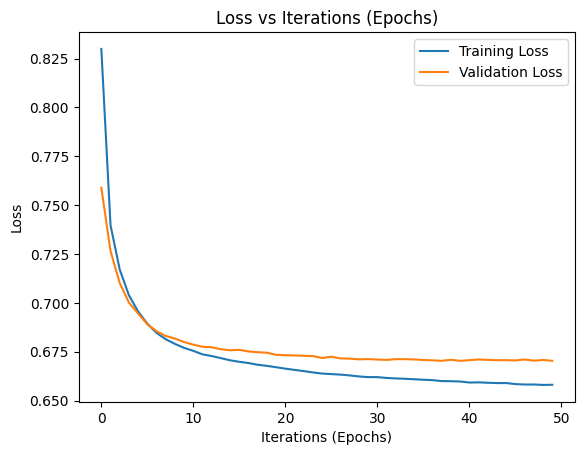


--- Fold 3/3 ---


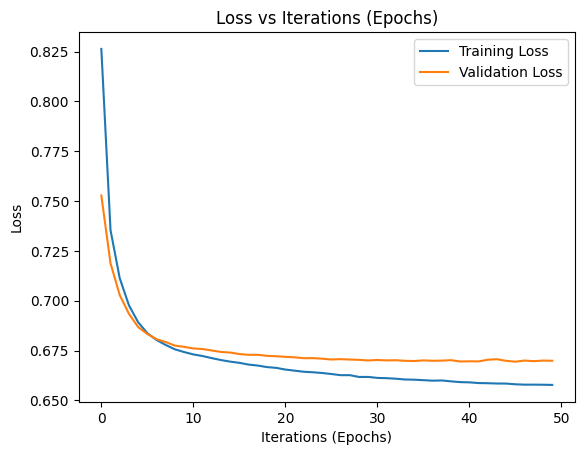

Max Nodes: 32, Layers: 2, Nodes: [32, 16], Avg Loss: 0.67133100827535

--- Fold 1/3 ---


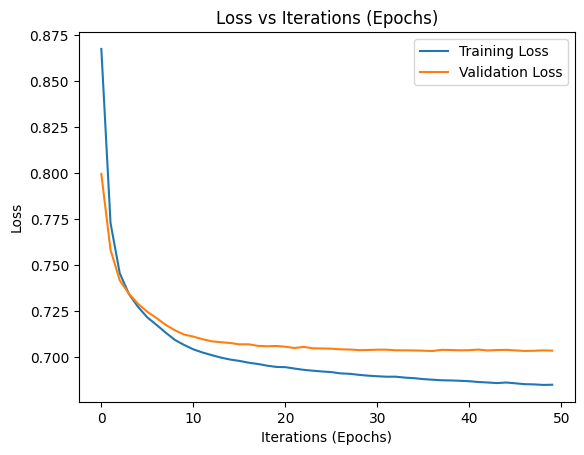


--- Fold 2/3 ---


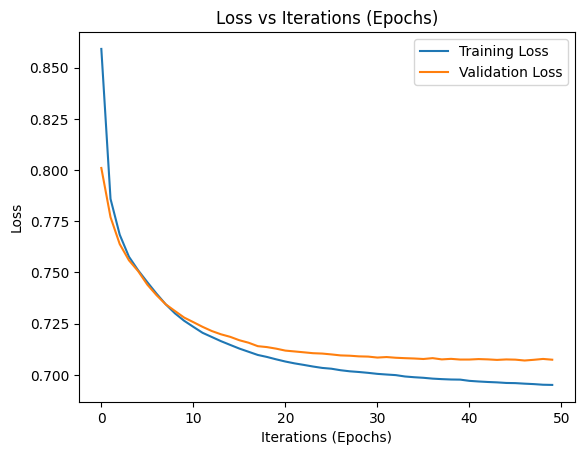


--- Fold 3/3 ---


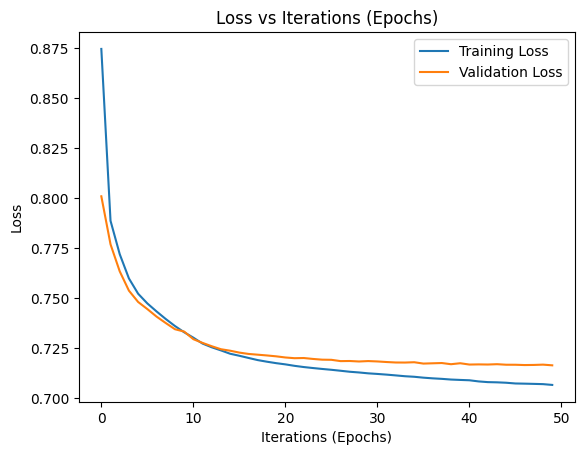

Max Nodes: 32, Layers: 3, Nodes: [32, 16, 8], Avg Loss: 0.7088906764984131

--- Fold 1/3 ---


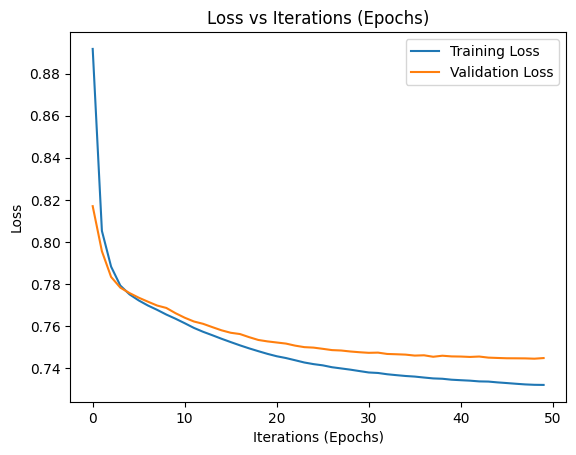


--- Fold 2/3 ---


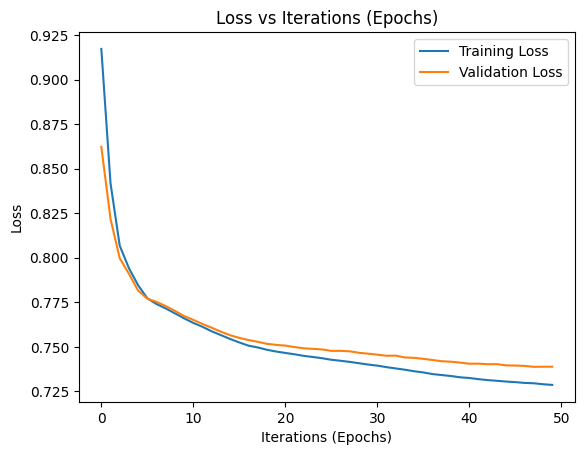


--- Fold 3/3 ---


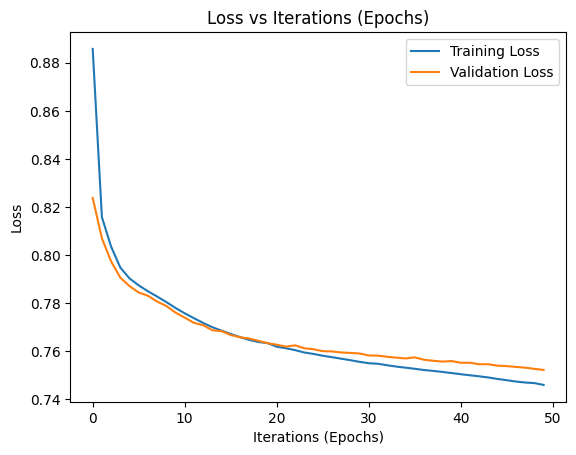

Max Nodes: 32, Layers: 4, Nodes: [32, 16, 8, 4], Avg Loss: 0.745144764582316

--- Fold 1/3 ---


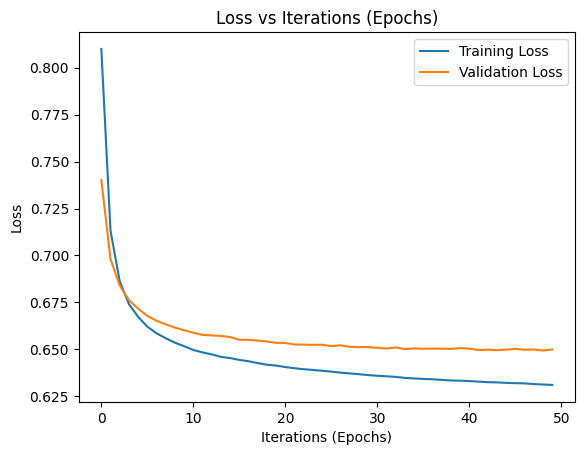


--- Fold 2/3 ---


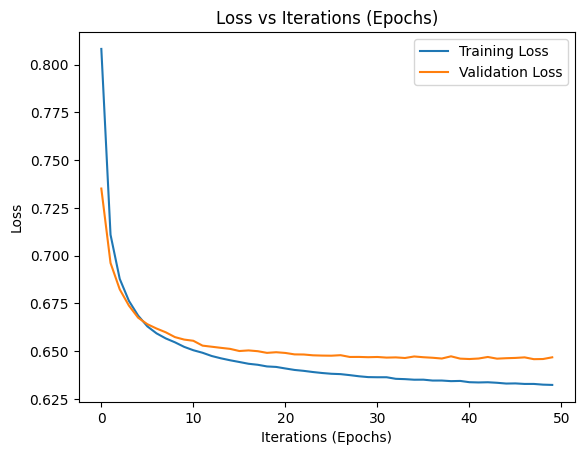


--- Fold 3/3 ---


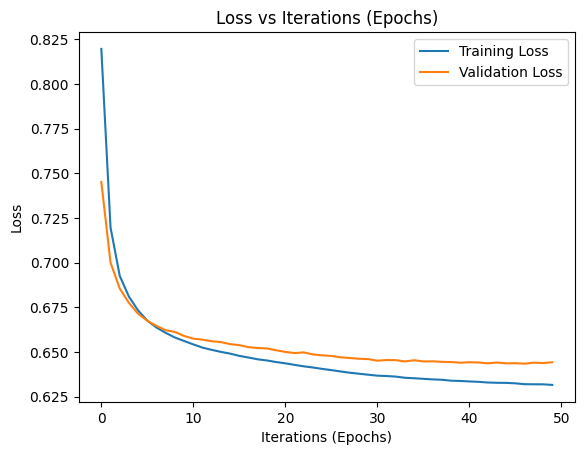

Max Nodes: 64, Layers: 2, Nodes: [64, 32], Avg Loss: 0.6462218960126241

--- Fold 1/3 ---


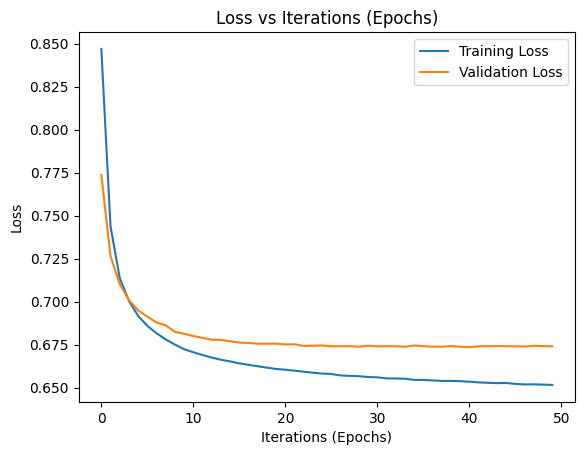


--- Fold 2/3 ---


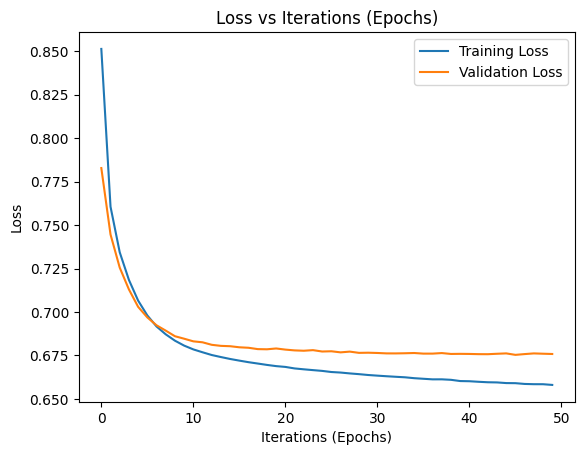


--- Fold 3/3 ---


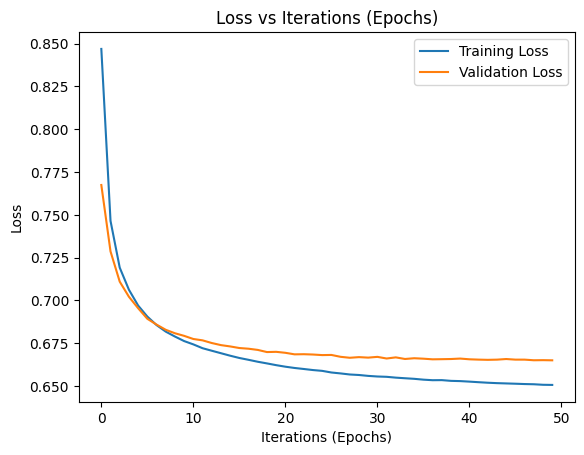

Max Nodes: 64, Layers: 3, Nodes: [64, 32, 16], Avg Loss: 0.6712913711865743

--- Fold 1/3 ---


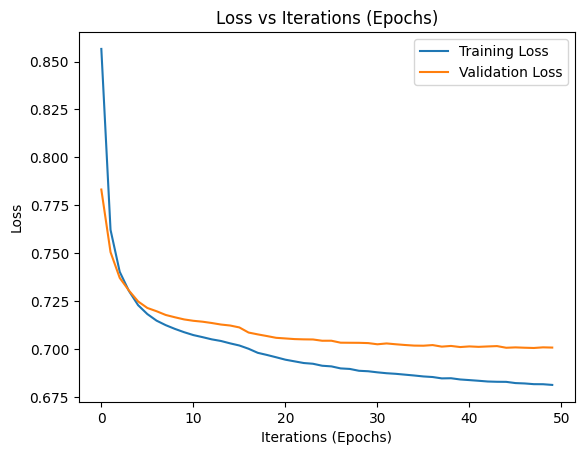


--- Fold 2/3 ---


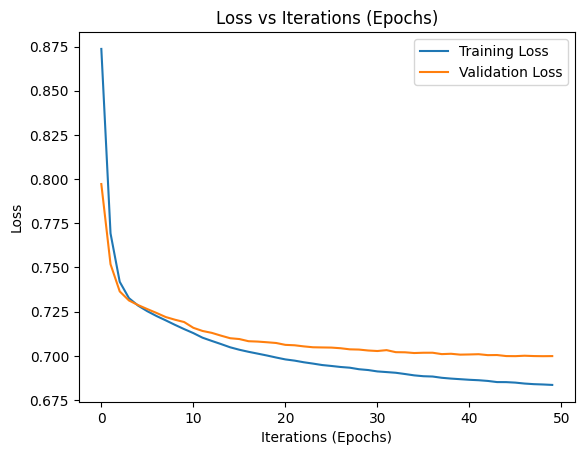


--- Fold 3/3 ---


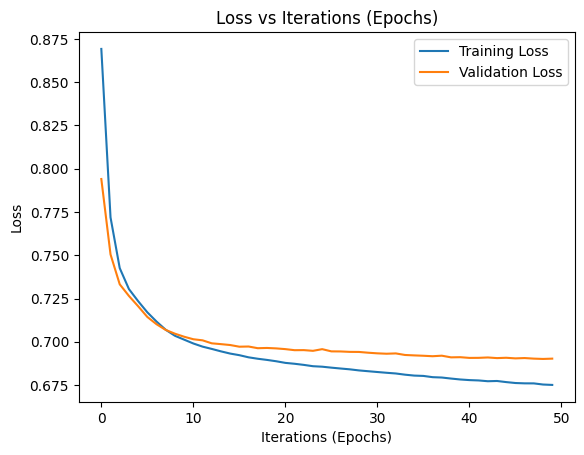

Max Nodes: 64, Layers: 4, Nodes: [64, 32, 16, 8], Avg Loss: 0.6968195041020712

--- Fold 1/3 ---


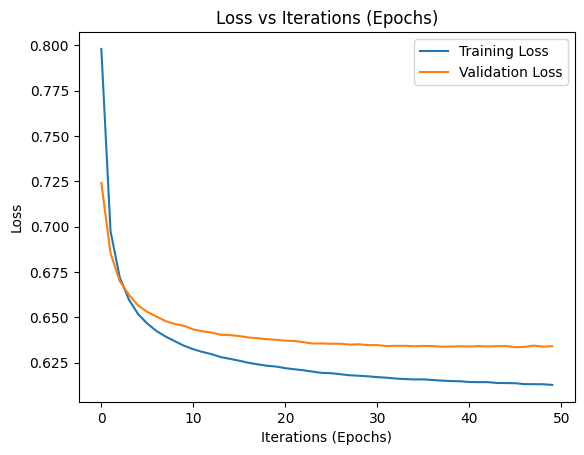


--- Fold 2/3 ---


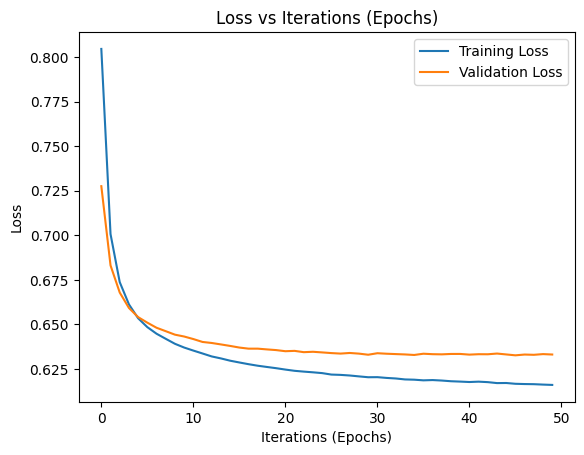


--- Fold 3/3 ---


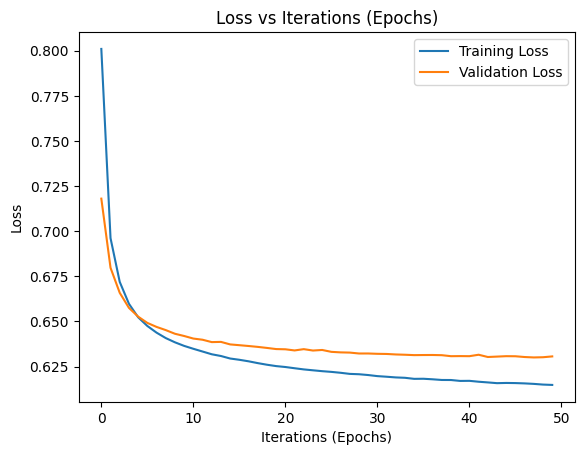

Max Nodes: 128, Layers: 2, Nodes: [128, 64], Avg Loss: 0.6320912639300028

--- Fold 1/3 ---


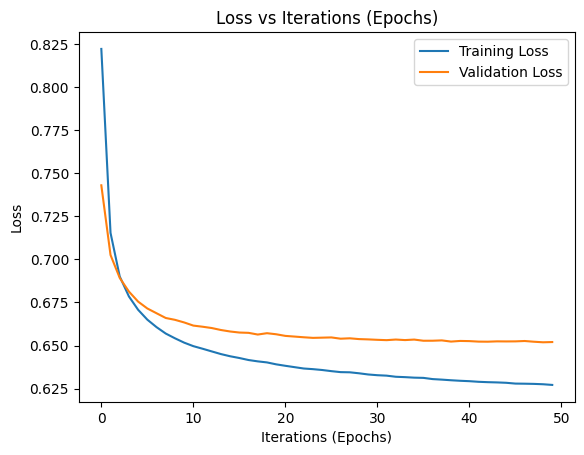


--- Fold 2/3 ---


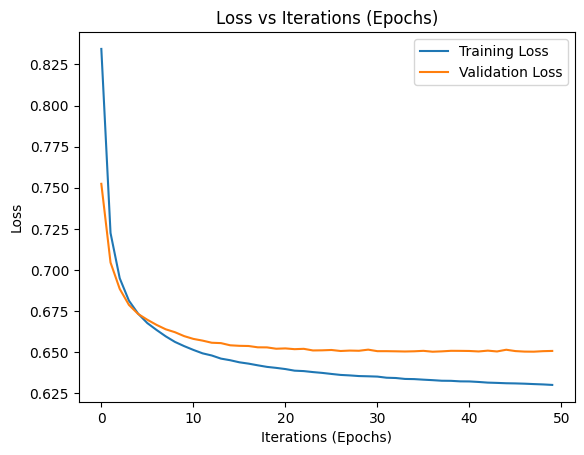


--- Fold 3/3 ---


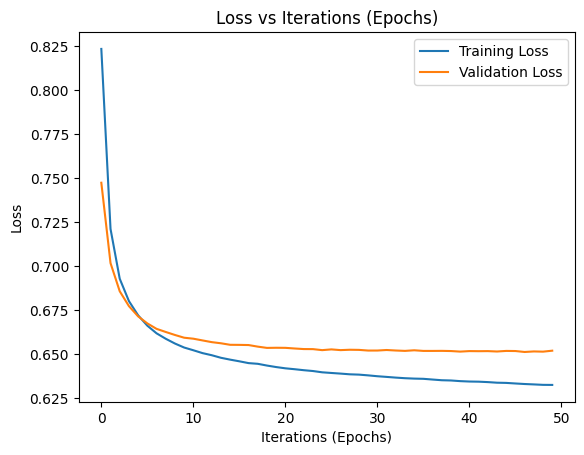

Max Nodes: 128, Layers: 3, Nodes: [128, 64, 32], Avg Loss: 0.6511984268824259

--- Fold 1/3 ---


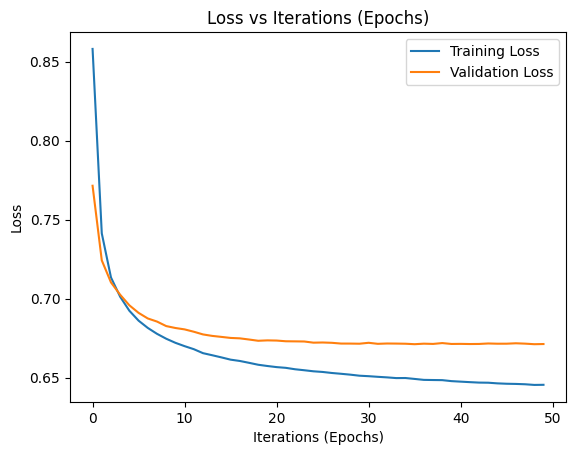


--- Fold 2/3 ---


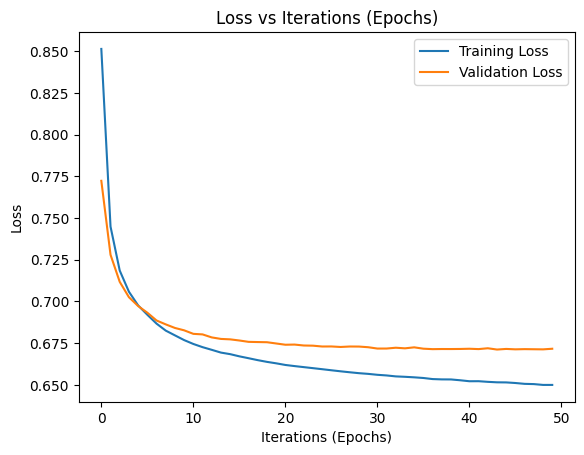


--- Fold 3/3 ---


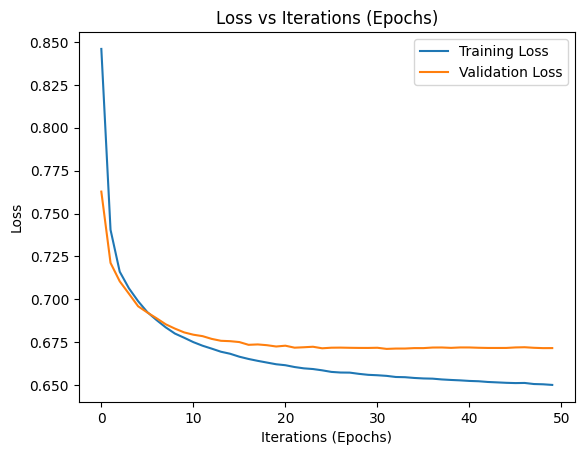

Max Nodes: 128, Layers: 4, Nodes: [128, 64, 32, 16], Avg Loss: 0.6711215575536092

Best Configuration: (128, 2, [128, 64]) with Best Loss: 0.6321
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - loss: 0.8514 - mse: 0.8514
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - loss: 0.6839 - mse: 0.6839
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - loss: 0.6608 - mse: 0.6608
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - loss: 0.6505 - mse: 0.6505
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - loss: 0.6454 - mse: 0.6454
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - loss: 0.6412 - mse: 0.6412
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - loss: 0.6380 - mse: 0.6380
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - loss: 0.6356 - mse: 0.6356
Epoch 9/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - loss: 0.6328 - mse: 0.6328
Epoch 10/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - loss: 0.6306 - mse: 0.6306
Epoch 11/50
1

Model saved as 'best_autoencoder.h5'


In [ ]:
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Function to generate nodes for the autoencoder architecture
def generate_nodes(max_nodes, num_layers):
    """
    Generate a list of nodes for the autoencoder's architecture.
    The number of nodes will decrease as the layers increase.
    """
    nodes = [max_nodes // (2 ** i) for i in range(num_layers)]
    return nodes

# Function to build an autoencoder model (as an example, modify this as needed)
def build_autoencoder(input_shape, nodes):
    """
    Build the autoencoder model based on the given nodes configuration.
    """
    input_layer = tf.keras.layers.Input(shape=(input_shape,))  # input_shape should match the flattened data
    encoded = input_layer

    # Create the encoder layers
    for node in nodes:
        encoded = tf.keras.layers.Dense(node, activation='relu')(encoded)

    # Create the decoder layers
    decoded = encoded
    for node in reversed(nodes[:-1]):
        decoded = tf.keras.layers.Dense(node, activation='relu')(decoded)

    # Final layer (reconstructed output)
    decoded = tf.keras.layers.Dense(input_shape, activation='linear')(decoded)  # Output shape matches input shape

    # Define the autoencoder model
    autoencoder = tf.keras.models.Model(input_layer, decoded)
    return autoencoder

# Function to perform cross-validation on the pre-trained autoencoder
def cross_validate_autoencoder_pretrained(autoencoder, dataset, k_folds=3, epochs=50, batch_size=128):
    """
    Perform cross-validation on the pre-trained autoencoder.
    The dataset is split into k folds, and the model's performance is evaluated.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Convert dataset to numpy array if it's a TensorFlow tensor
    dataset = dataset.numpy() if isinstance(dataset, tf.Tensor) else dataset
    dataset = dataset.reshape(dataset.shape[0], -1)  # Flatten images for evaluation if necessary

    fold_losses = []
    best_loss = float('inf')
    best_config = None

    for max_nodes in max_nodes_list:
        for num_layers in num_layers_list:
            nodes = generate_nodes(max_nodes, num_layers)
            fold_losses = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
                print(f"\n--- Fold {fold + 1}/{k_folds} ---")

                # Split the dataset into training and validation sets
                train_data, val_data = dataset[train_idx], dataset[val_idx]

                # Build and compile the autoencoder model
                autoencoder = build_autoencoder(train_data.shape[1], nodes)
                autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

                # Train the model on the current fold
                history = autoencoder.fit(
                    train_data, train_data,
                    validation_data=(val_data, val_data),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0
                )

                # Plot the loss for each fold
                plt.plot(history.history['loss'], label='Training Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title('Loss vs Iterations (Epochs)')
                plt.xlabel('Iterations (Epochs)')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

                # Append the minimum validation loss from this fold
                fold_losses.append(min(history.history['val_loss']))

            # Compute average validation loss for the current configuration
            avg_loss = np.mean(fold_losses)
            print(f"Max Nodes: {max_nodes}, Layers: {num_layers}, Nodes: {nodes}, Avg Loss: {avg_loss}")

            # Track the best configuration
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_config = (max_nodes, num_layers, nodes)

    print(f"\nBest Configuration: {best_config} with Best Loss: {best_loss:.4f}")

    # Retrain the best model on the full dataset
    best_autoencoder = build_autoencoder(dataset.shape[1], best_config[2])
    best_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Train the best model on the full dataset
    best_autoencoder.fit(dataset, dataset, epochs=epochs, batch_size=batch_size)

    # Save the trained best model
    best_autoencoder.save('best_autoencoder.h5')
    print("Model saved as 'best_autoencoder.h5'")

    return best_config


# Example usage: Cross-validation for different configurations
max_nodes_list = [32, 64, 128]
num_layers_list = [2, 3, 4]

# Assume train_images_resized is your dataset (ensure it's a NumPy array or TensorFlow tensor)
# Example: train_images_resized = np.random.rand(1000, 784)  # Example dataset, replace with actual data

# If your images are in 4D (e.g., 112x112x3), reshape them here to (num_samples, 112 * 112 * 3)
# train_images_resized is assumed to be a TensorFlow tensor, so we reshape it using tf.reshape()
print(f"Original shape: {train_images_resized.shape}")

# Reshape the images to (num_samples, 112 * 112 * 3) to flatten the 3 channels (RGB)
train_images_resized = tf.reshape(train_images_resized, (train_images_resized.shape[0], 112 * 112 * 3))

# Verify the new shape after reshaping
print(f"New shape after reshaping: {train_images_resized.shape}")

# Perform cross-validation to find the best configuration
best_config = cross_validate_autoencoder_pretrained(None, train_images_resized, k_folds=3, epochs=50, batch_size=128)


Original shape: (14137, 112, 112, 3)
New shape after reshaping: (14137, 37632)
Evaluating config: Max Nodes = 32, Layers = 2, Nodes = [32, 16]

--- Fold 1/3 ---


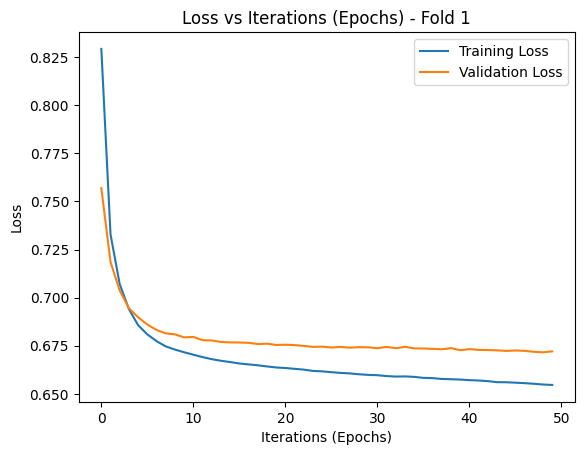


--- Fold 2/3 ---


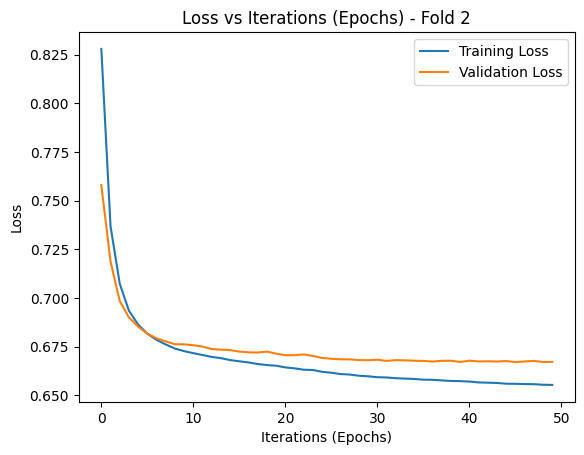


--- Fold 3/3 ---


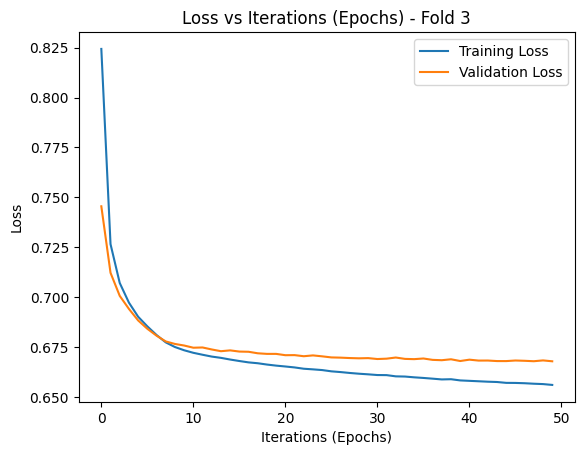

Max Nodes: 32, Layers: 2, Nodes: [32, 16], Avg Loss: 0.668846607208252
Evaluating config: Max Nodes = 32, Layers = 3, Nodes = [32, 16, 8]

--- Fold 1/3 ---


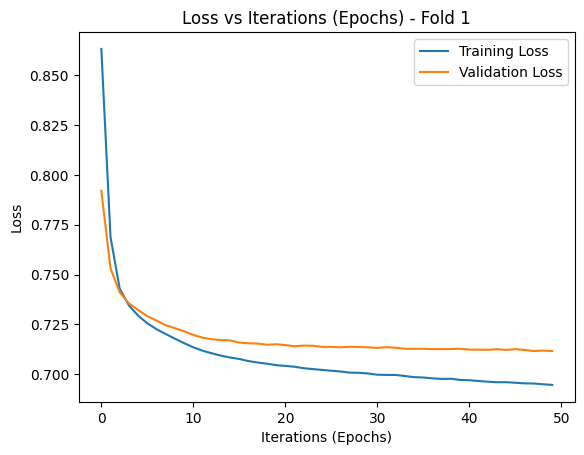


--- Fold 2/3 ---


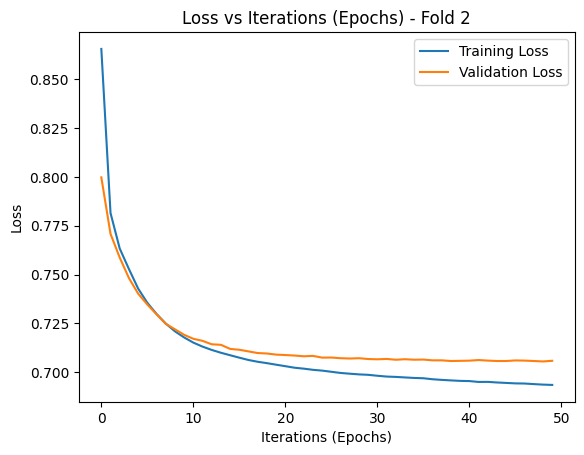


--- Fold 3/3 ---


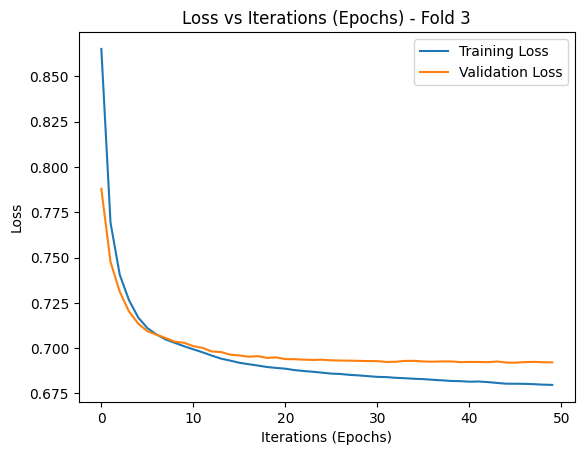

Max Nodes: 32, Layers: 3, Nodes: [32, 16, 8], Avg Loss: 0.7030227780342102
Evaluating config: Max Nodes = 32, Layers = 4, Nodes = [32, 16, 8, 4]

--- Fold 1/3 ---


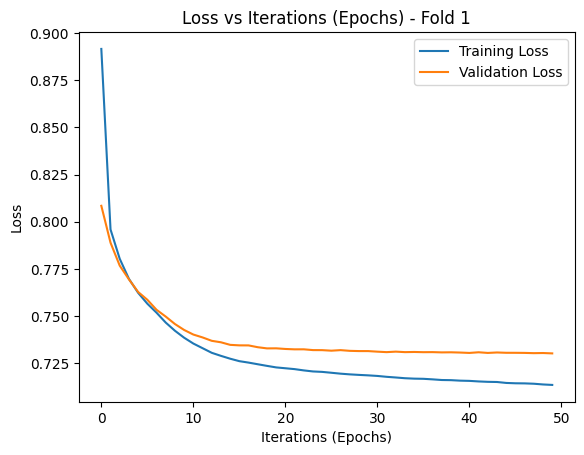


--- Fold 2/3 ---


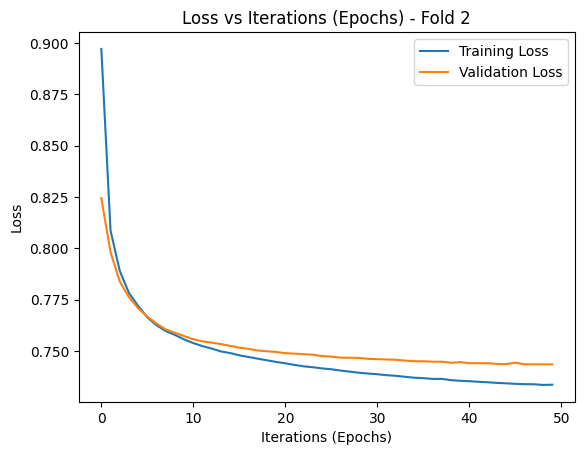


--- Fold 3/3 ---


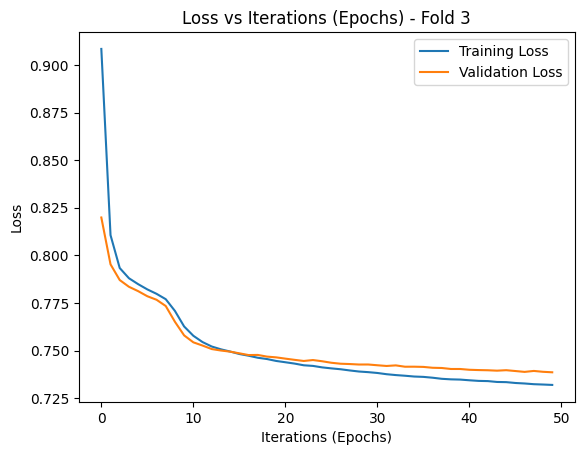

Max Nodes: 32, Layers: 4, Nodes: [32, 16, 8, 4], Avg Loss: 0.7374433875083923
Evaluating config: Max Nodes = 64, Layers = 2, Nodes = [64, 32]

--- Fold 1/3 ---


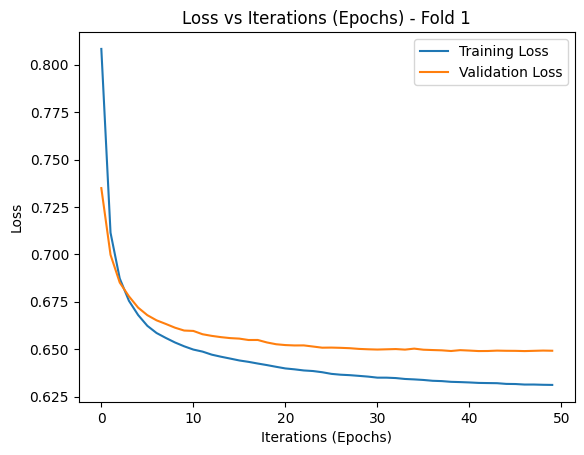


--- Fold 2/3 ---


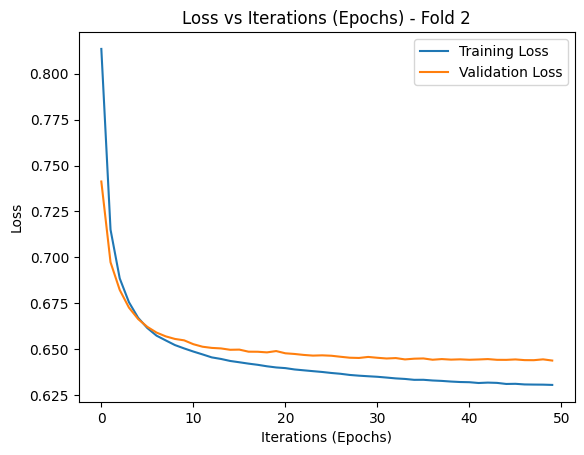


--- Fold 3/3 ---


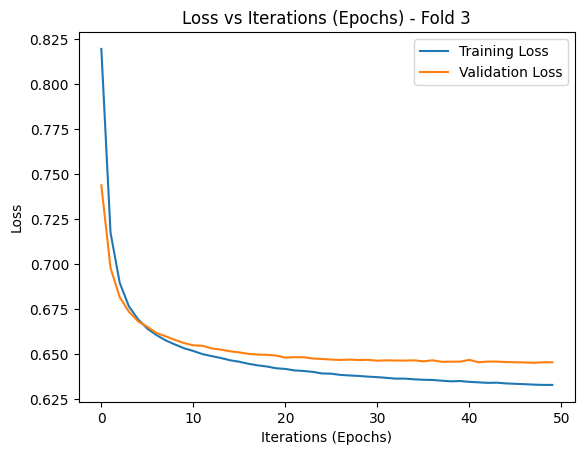

Max Nodes: 64, Layers: 2, Nodes: [64, 32], Avg Loss: 0.6460057497024536
Evaluating config: Max Nodes = 64, Layers = 3, Nodes = [64, 32, 16]

--- Fold 1/3 ---


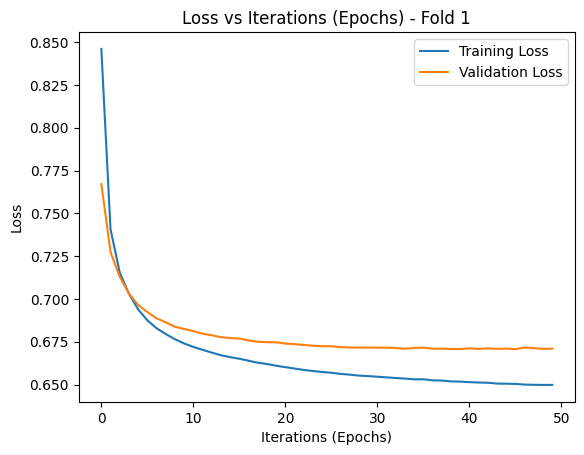


--- Fold 2/3 ---


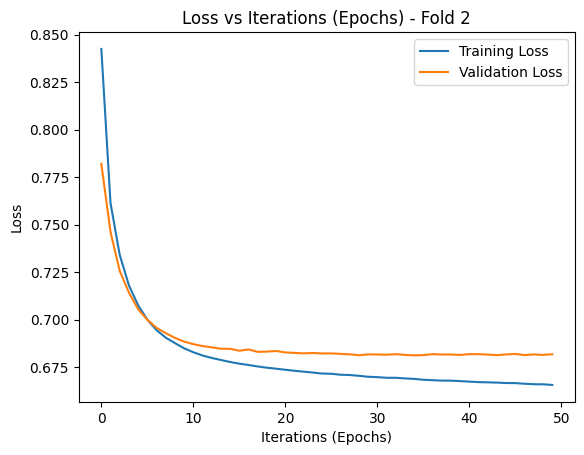


--- Fold 3/3 ---


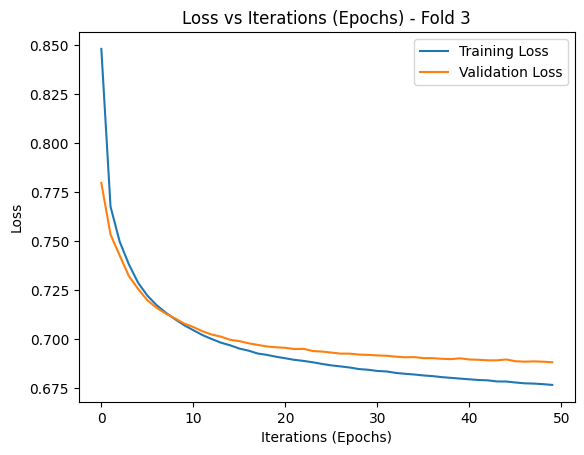

Max Nodes: 64, Layers: 3, Nodes: [64, 32, 16], Avg Loss: 0.680110494295756
Evaluating config: Max Nodes = 64, Layers = 4, Nodes = [64, 32, 16, 8]

--- Fold 1/3 ---


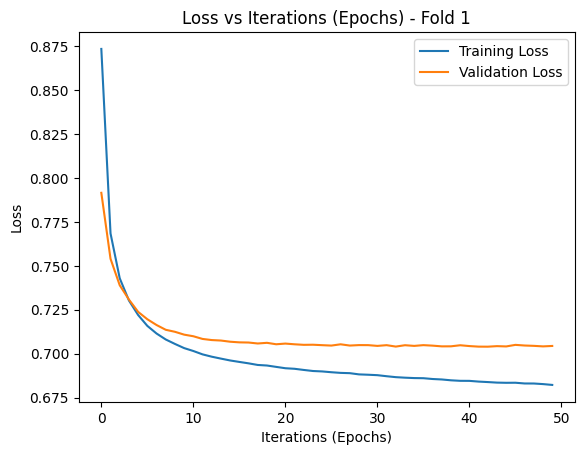


--- Fold 2/3 ---


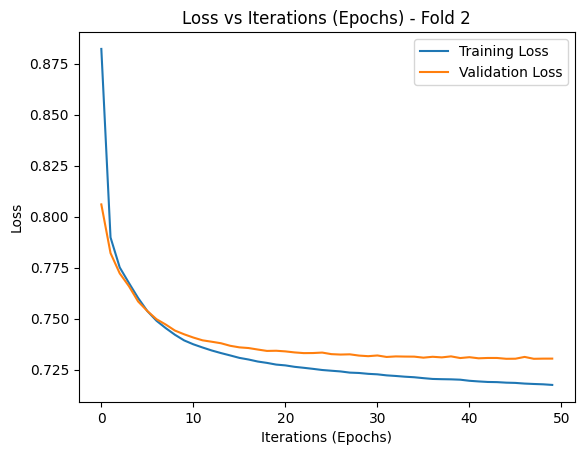


--- Fold 3/3 ---


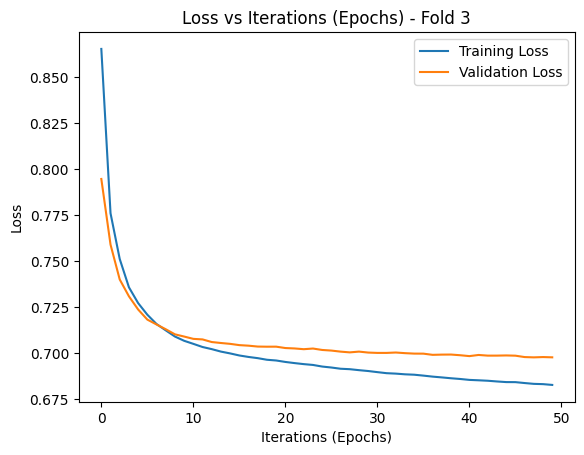

Max Nodes: 64, Layers: 4, Nodes: [64, 32, 16, 8], Avg Loss: 0.7106181184450785
Evaluating config: Max Nodes = 128, Layers = 2, Nodes = [128, 64]

--- Fold 1/3 ---


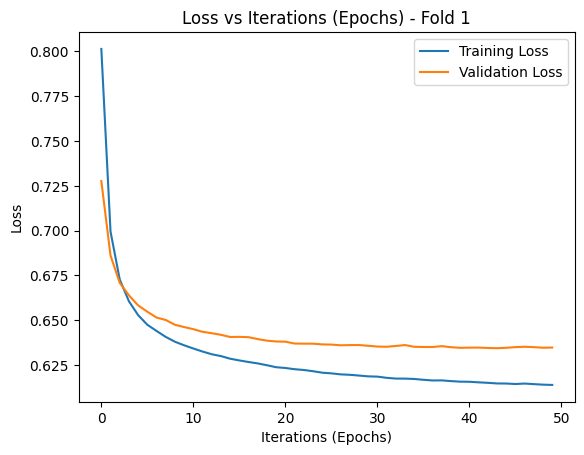


--- Fold 2/3 ---


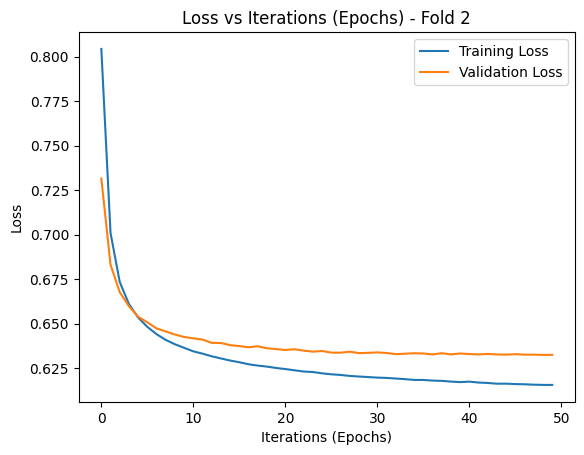


--- Fold 3/3 ---


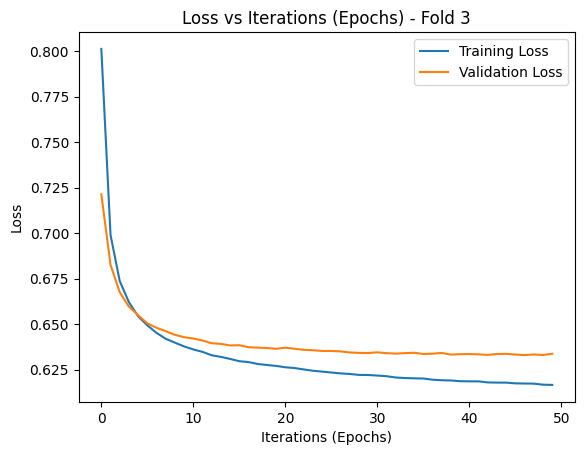

Max Nodes: 128, Layers: 2, Nodes: [128, 64], Avg Loss: 0.6332782109578451
Evaluating config: Max Nodes = 128, Layers = 3, Nodes = [128, 64, 32]

--- Fold 1/3 ---


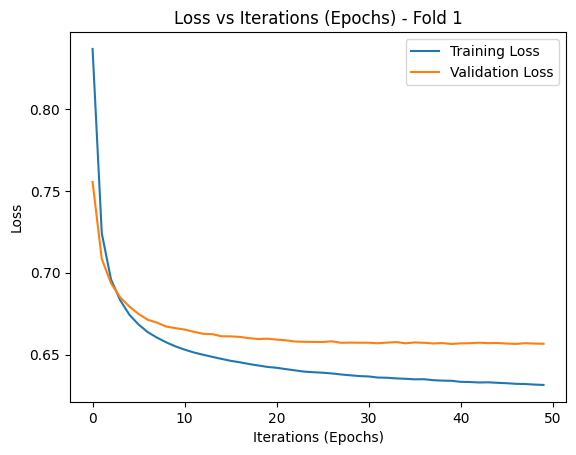


--- Fold 2/3 ---


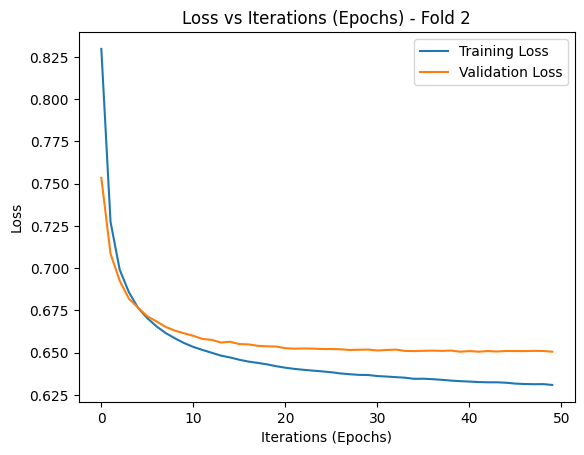


--- Fold 3/3 ---


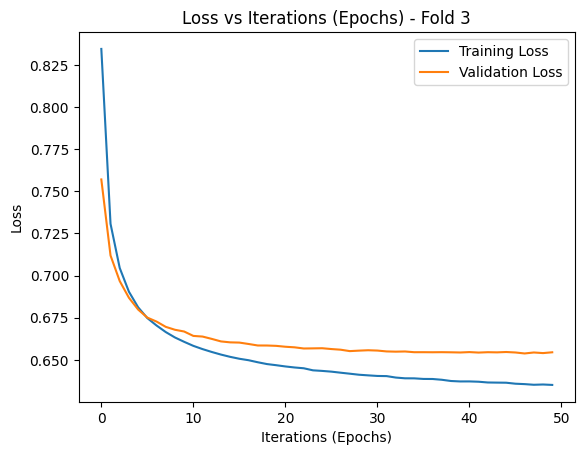

Max Nodes: 128, Layers: 3, Nodes: [128, 64, 32], Avg Loss: 0.6536384622255961
Evaluating config: Max Nodes = 128, Layers = 4, Nodes = [128, 64, 32, 16]

--- Fold 1/3 ---


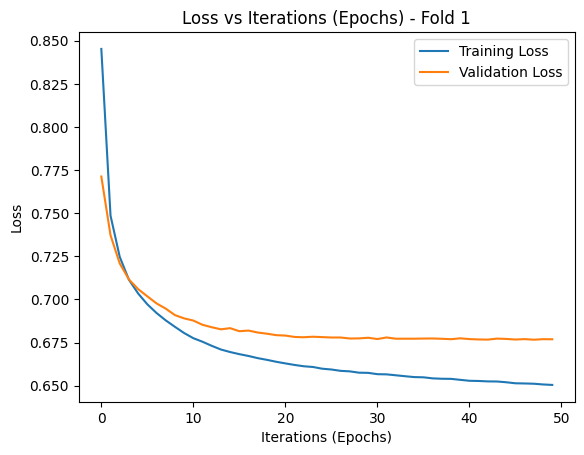


--- Fold 2/3 ---


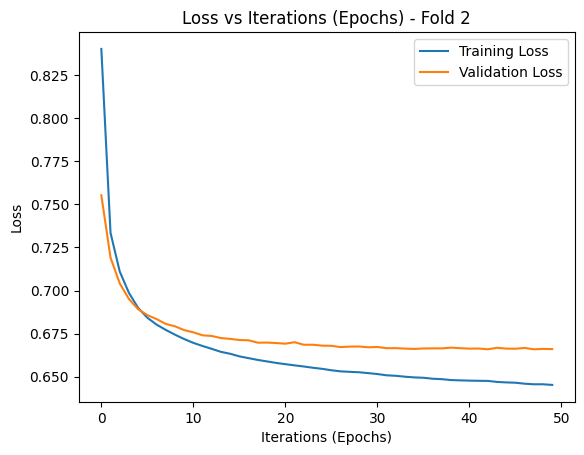


--- Fold 3/3 ---


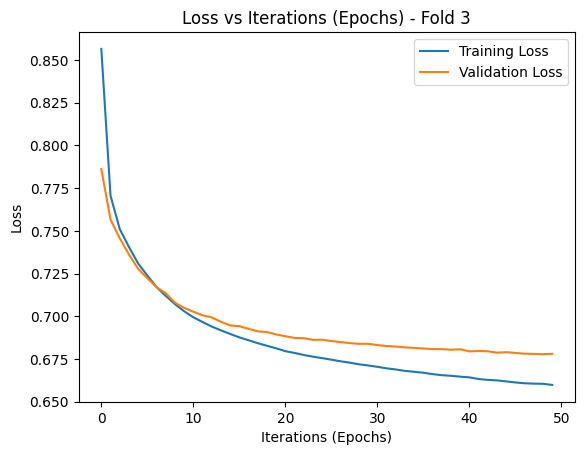

Max Nodes: 128, Layers: 4, Nodes: [128, 64, 32, 16], Avg Loss: 0.6734528342882792

Best Configuration: (128, 2, [128, 64]) with Best Loss: 0.6333
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - loss: 0.8580 - mse: 0.8580
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - loss: 0.6856 - mse: 0.6856
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - loss: 0.6601 - mse: 0.6601
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - loss: 0.6511 - mse: 0.6511
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - loss: 0.6454 - mse: 0.6454
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - loss: 0.6401 - mse: 0.6401
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - loss: 0.6370 - mse: 0.6370
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - loss: 0.6343 - mse: 0.6343
Epoch 9/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - loss: 0.6322 - mse: 0.6322
Epoch 10/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - loss: 0.6319 - mse: 0.6319
Epoch 11/50
1

Model saved as 'best_autoencoder.h5'


In [ ]:
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Function to generate nodes for the autoencoder architecture
def generate_nodes(max_nodes, num_layers):
    """
    Generate a list of nodes for the autoencoder's architecture.
    The number of nodes will decrease as the layers increase.
    """
    nodes = [max_nodes // (2 ** i) for i in range(num_layers)]
    return nodes

# Function to build an autoencoder model (as an example, modify this as needed)
def build_autoencoder(input_shape, nodes):
    """
    Build the autoencoder model based on the given nodes configuration.
    """
    input_layer = tf.keras.layers.Input(shape=(input_shape,))  # input_shape should match the flattened data
    encoded = input_layer

    # Create the encoder layers
    for node in nodes:
        encoded = tf.keras.layers.Dense(node, activation='relu')(encoded)

    # Create the decoder layers
    decoded = encoded
    for node in reversed(nodes[:-1]):
        decoded = tf.keras.layers.Dense(node, activation='relu')(decoded)

    # Final layer (reconstructed output)
    decoded = tf.keras.layers.Dense(input_shape, activation='linear')(decoded)  # Output shape matches input shape

    # Define the autoencoder model
    autoencoder = tf.keras.models.Model(input_layer, decoded)
    return autoencoder

# Function to perform cross-validation on the pre-trained autoencoder
def cross_validate_autoencoder_pretrained(autoencoder, dataset, max_nodes_list, num_layers_list, k_folds=3, epochs=50, batch_size=128):
    """
    Perform cross-validation on the pre-trained autoencoder.
    The dataset is split into k folds, and the model's performance is evaluated.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Convert dataset to numpy array if it's a TensorFlow tensor
    dataset = dataset.numpy() if isinstance(dataset, tf.Tensor) else dataset
    dataset = dataset.reshape(dataset.shape[0], -1)  # Flatten images for evaluation if necessary

    fold_losses = []
    best_loss = float('inf')
    best_config = None

    # Iterate through different configurations of max_nodes and num_layers
    for max_nodes in max_nodes_list:
        for num_layers in num_layers_list:
            nodes = generate_nodes(max_nodes, num_layers)
            fold_losses = []  # Clear fold_losses for each new configuration

            print(f"Evaluating config: Max Nodes = {max_nodes}, Layers = {num_layers}, Nodes = {nodes}")

            # Cross-validation loop
            for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
                print(f"\n--- Fold {fold + 1}/{k_folds} ---")

                # Split the dataset into training and validation sets
                train_data, val_data = dataset[train_idx], dataset[val_idx]

                # Build and compile the autoencoder model
                autoencoder = build_autoencoder(train_data.shape[1], nodes)
                autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

                # Train the model on the current fold
                history = autoencoder.fit(
                    train_data, train_data,
                    validation_data=(val_data, val_data),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0
                )

                # Plot the loss for each fold
                plt.plot(history.history['loss'], label='Training Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title(f'Loss vs Iterations (Epochs) - Fold {fold + 1}')
                plt.xlabel('Iterations (Epochs)')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

                # Append the minimum validation loss from this fold
                fold_losses.append(min(history.history['val_loss']))

            # Compute average validation loss for the current configuration
            avg_loss = np.mean(fold_losses)
            print(f"Max Nodes: {max_nodes}, Layers: {num_layers}, Nodes: {nodes}, Avg Loss: {avg_loss}")

            # Track the best configuration
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_config = (max_nodes, num_layers, nodes)

    print(f"\nBest Configuration: {best_config} with Best Loss: {best_loss:.4f}")

    # Retrain the best model on the full dataset
    best_autoencoder = build_autoencoder(dataset.shape[1], best_config[2])
    best_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Train the best model on the full dataset
    best_autoencoder.fit(dataset, dataset, epochs=epochs, batch_size=batch_size)

    # Save the trained best model
    best_autoencoder.save('best_autoencoder.h5')
    print("Model saved as 'best_autoencoder.h5'")

    return best_config


# Example usage: Cross-validation for different configurations
max_nodes_list = [32, 64, 128]
num_layers_list = [2, 3, 4]

# Assume train_images_resized is your dataset (ensure it's a NumPy array or TensorFlow tensor)
# Example: train_images_resized = np.random.rand(1000, 784)  # Example dataset, replace with actual data

# If your images are in 4D (e.g., 112x112x3), reshape them here to (num_samples, 112 * 112 * 3)
# train_images_resized is assumed to be a TensorFlow tensor, so we reshape it using tf.reshape()
print(f"Original shape: {train_images_resized.shape}")

# Reshape the images to (num_samples, 112 * 112 * 3) to flatten the 3 channels (RGB)
train_images_resized = tf.reshape(train_images_resized, (train_images_resized.shape[0], 112 * 112 * 3))

# Verify the new shape after reshaping
print(f"New shape after reshaping: {train_images_resized.shape}")

# Perform cross-validation to find the best configuration
best_config = cross_validate_autoencoder_pretrained(None, train_images_resized, max_nodes_list, num_layers_list, k_folds=3, epochs=50, batch_size=128)


In [ ]:
print(f"Original shape: {train_images_resized.shape}")


Original shape: (14137, 112, 112, 3)
